## Segmentation map으로 도로 이미지 만들기
---
- 기존의 포켓몬 데이터에서 사용했던 스케치와는 조금 다른 레이블 정보 이미지를 입력으로 사용한다
    - 전처리부분에서 조금 다르다
- [TensorFlow pix2pix tutorial](tensorflow.org/tutorials/generative/pix2pix?hl=ko) 참고
    - 여기서는 pix2pix구조를 functional api를 이용해서 구현하기 때문에 이번에 진행한 subclassing 방법을 이용한 모델과 비교해본다.
    - 나는 functional이 더 좋다.
- 필수로 수행해야 할 사항
    1. 데이터에 1가지 이상의 augmentation 방법을 적용해 학습해라.(어떠한 방법을 사용했는지 적는다)
    2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 Skip connection이 있는 U-Net Generator를 사용한다.
    3. 모델 학습 후, 학습된 Generator를 이용해 테스트한다. 테스트 데이터는 다운받았던 "val"폴더 내에서 아무 이미지나 사용한다.  
        1개 이상의 이미지에 대해 테스트과정을 거친 후 그 결과를 (스케치, 생성된 사진, 실제 사진)순서로 나란히 시각화한다.
    4. 모델을 충분히 학습하기에 시간이 부족할 수 있다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남긴다..(어떻게?)  
        결과 자체는 만족스럽지 않을 수 있다.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Input, Model

In [2]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


기존의 포켓몬 이미지의 경우 좌측에는 채색이 전혀 없는 윤곽선만 주어지고 그에 대한 color이미지가 우측에 나왔지만 이번에는 원본사진과 segmentation(그냥 색만 칠해진) 사진이 있다.  
- 두 가지 방법을 생각했다.
    1. 가장 처음 생각나는 것은 이미지를 이진화하여서 gray scale로 표현한다.
    2. 혹은 edge만 추출하여서 사용한다.
- 기존에 opencv에서 지원해주는 메소드를 활용해서 사용할 수 있을 것.. 아마도

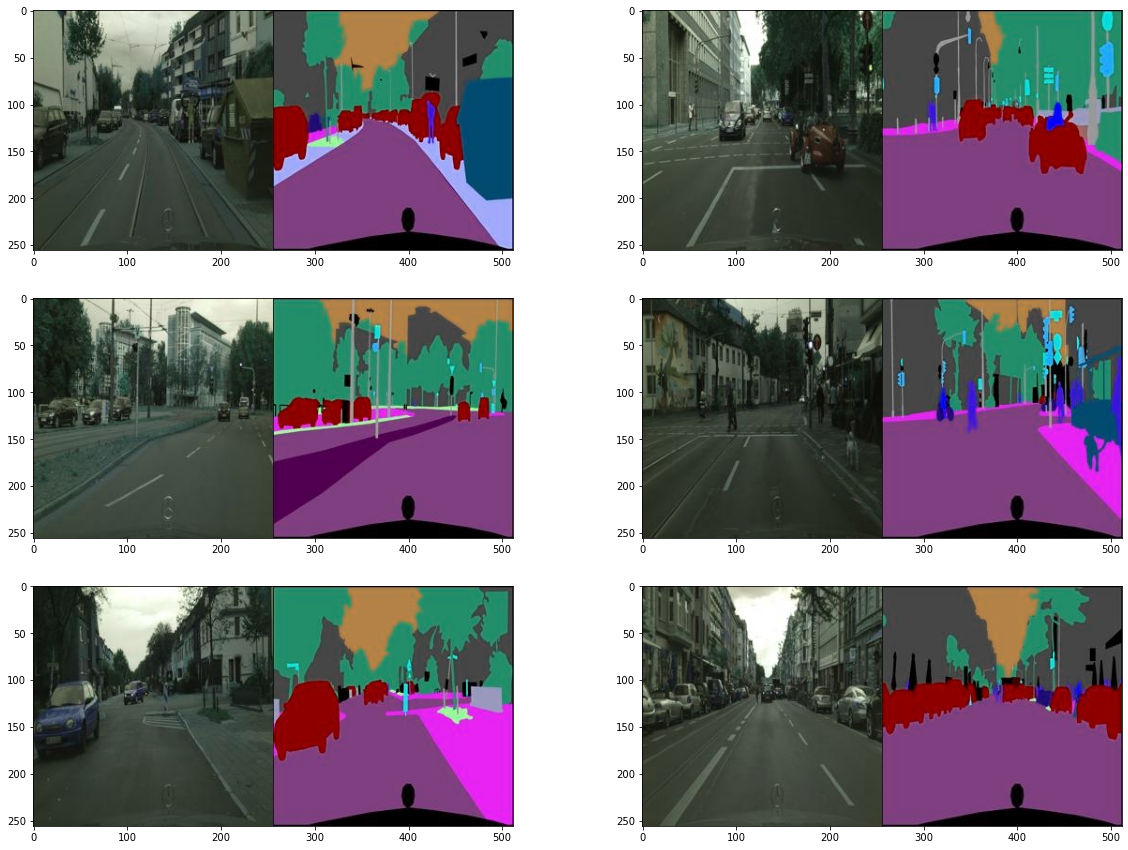

In [3]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


붙어있는 두개의 이미지 사진을 나눈다.
- ```normalize``` 함수
- ```denormalize```함수
    - 이후에 시각화(matplotlib)를 통해서 보여주기 위해서는 정규화 되어있는 사진을 다시 원래대로 변환해서 시각화한다.
- ```load_img```함수
    - 이미지를 읽고 decode를 해서 array에 담는다
    - w에는 512인 너비를 반을 나눠서 256의 값이 되고
    - 좌측 반은 sketch로 저장, 우측은 colored로 저장..
    - 그리고 두 개로 나눈 이미지는 normalize를 적용시키면서 반환시킨다

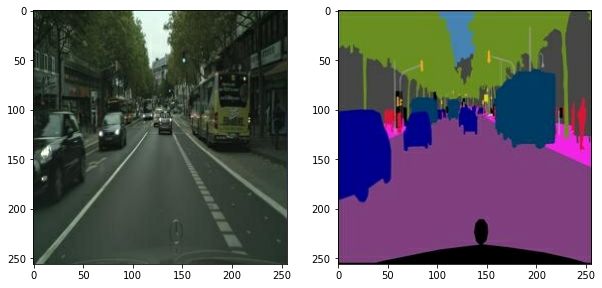

In [5]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

아래에서 사용한 방법은 다음과 같다.
1. 두 이미지가 채널 축으로 연결
2. 1의 결과에 50% 확률로 Reflection padding, constant padding이 30픽셀의 pad width만큼 적용
3. 2의 결과에서 (256, 256, 6) 크기를 가진 이미지를 임의로 잘라낸다
4. 3의 결과물을 50%의 확률로 가로 반전
- 세로반전과 회전은 수행하지 않는다.
    - 일반적으로 도로사진은 그런 사진이 없기 때문에
- 의문점
    - 이미지를 concat시키지 않고 짤릴 경우 기존에 이미지는 하얀색 배경이라서 하얀색이 있는게 문제가 되지 않지만, 도로 이미지의 경우 기존에 segmap에는 색칠이 다 되어 있기 때문에 흰색이 오히려 학습에 도움이 되지 않을 것 같다.
    ![image](https://user-images.githubusercontent.com/48716219/98461359-d5edda00-21ee-11eb-8c6c-6cd0876cd2e1.png)


In [6]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    
    return out[...,:3], out[...,3:]   

print("✅")

✅


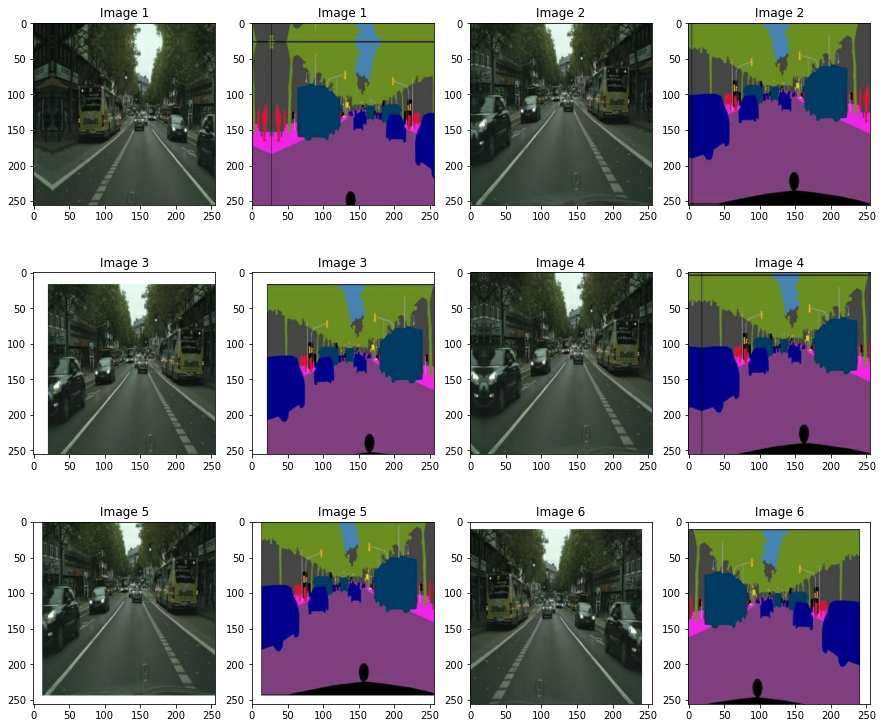

In [7]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

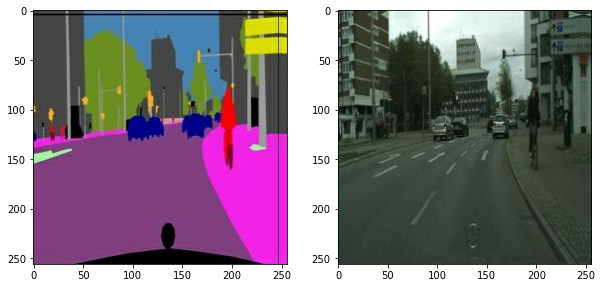

In [8]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return colored, sketch

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

# Generator 정의
---
- U-Net Generator를 사용한다
    - Encoder와 Decoder간의 skip connection이 존재

## EncodeBlock과 DecodeBlock 정의

In [9]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)
    
print("✅")

✅


In [10]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

print("✅")

✅


In [11]:
UNetGenerator().get_summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
_______________________________________________________________________________________

# Diecriminator 구성하기

In [12]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

print("✅")

✅


In [13]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_15 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [14]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
print("✅")

✅


In [15]:
Discriminator().get_summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]   

In [16]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

print("✅")

✅


In [17]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

print("✅")

✅


In [18]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

print("✅")

✅


In [19]:
EPOCHS = 50

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.0539                     
L1_loss:0.3571                     
Discriminator_loss:1.2774

EPOCH[1] - STEP[20]                     
Generator_loss:1.0601                     
L1_loss:0.2137                     
Discriminator_loss:1.2466

EPOCH[1] - STEP[30]                     
Generator_loss:1.1104                     
L1_loss:0.2185                     
Discriminator_loss:1.3776

EPOCH[1] - STEP[40]                     
Generator_loss:0.9371                     
L1_loss:0.2010                     
Discriminator_loss:1.2195

EPOCH[1] - STEP[50]                     
Generator_loss:0.9657                     
L1_loss:0.1675                     
Discriminator_loss:1.3379

EPOCH[1] - STEP[60]                     
Generator_loss:0.9329                     
L1_loss:0.2073                     
Discriminator_loss:1.0923

EPOCH[1] - STEP[70]                     
Generator_loss:1.2164                     
L1_loss:0.1916                    

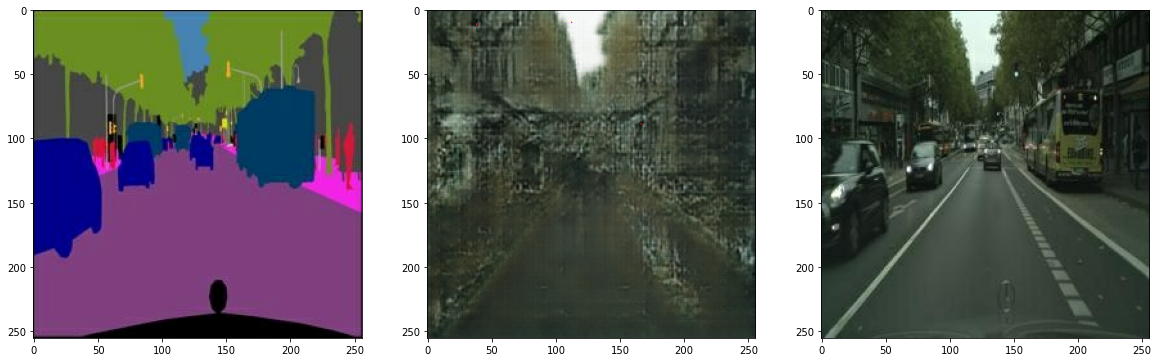

In [20]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(colored))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(sketch))

In [23]:
os.listdir('cityscapes/val')

['3.jpg', '5.jpg', '4.jpg', '1.jpg', '2.jpg']

In [25]:
from glob import glob
val_paths = glob('cityscapes/val/*')
val_paths

['cityscapes/val/3.jpg',
 'cityscapes/val/5.jpg',
 'cityscapes/val/4.jpg',
 'cityscapes/val/1.jpg',
 'cityscapes/val/2.jpg']

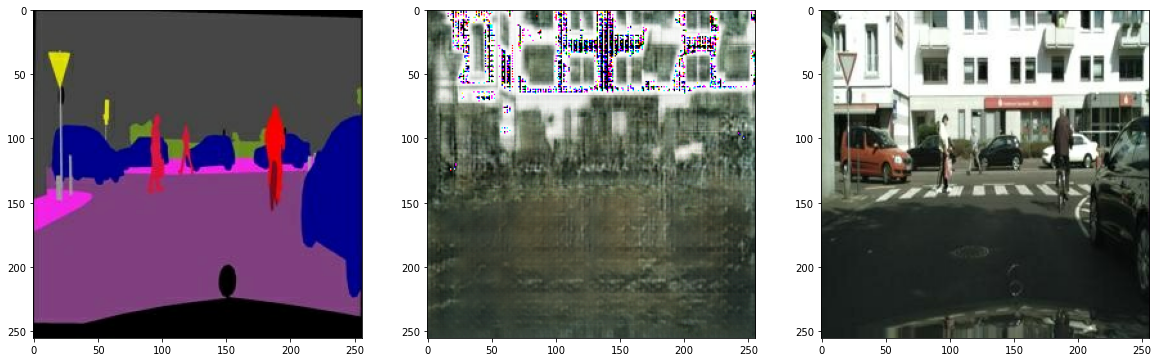

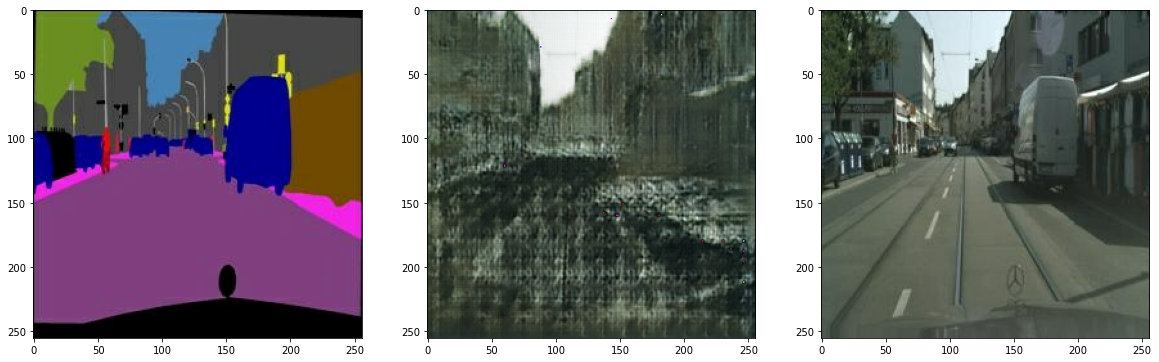

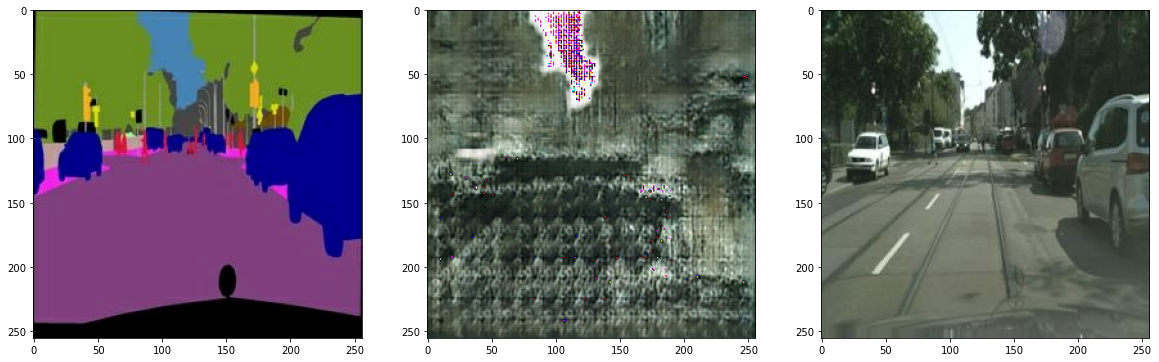

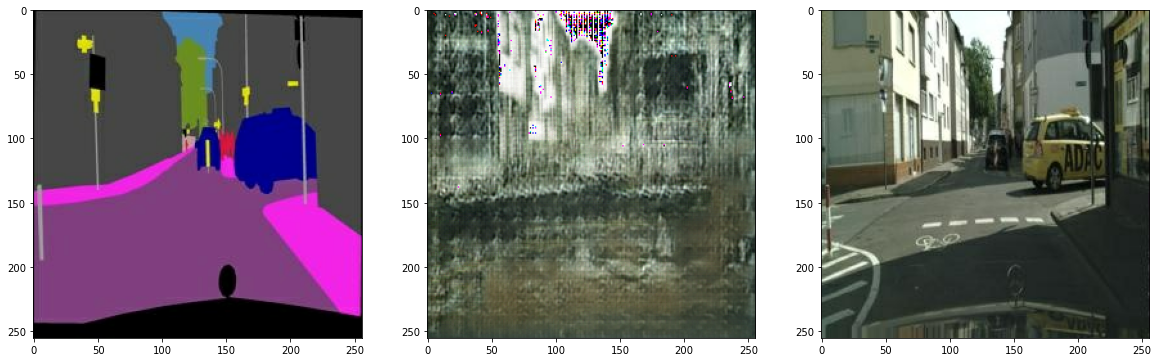

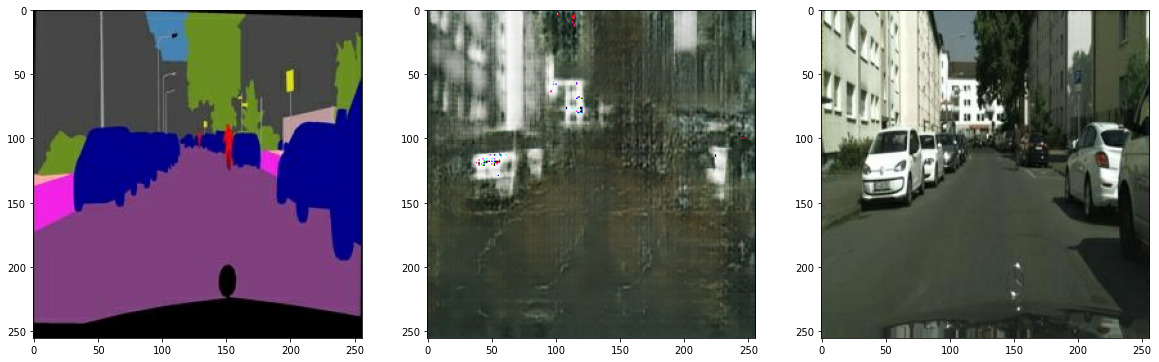

In [29]:
from PIL import Image
for path in val_paths :
    sketch, colored = load_img(path)
    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(colored))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(sketch))
    plt.show()

# 정리
---
1. Augmentation적용
    1. 두 이미지가 채널 축으로 연결
    2. 1의 결과에 50% 확률로 Reflection padding, constant padding이 30픽셀의 pad width만큼 적용
    3. 2의 결과에서 (256, 256, 6) 크기를 가진 이미지를 임의로 잘라낸다
    4. 3의 결과물을 50%의 확률로 가로 반전
    - 세로반전과 회전은 수행하지 않는다.
        - 일반적으로 도로사진은 그런 사진이 없기 때문에
    - 의문점
        - 이미지를 concat시키지 않고 짤릴 경우 기존에 이미지는 하얀색 배경이라서 하얀색이 있는게 문제가 되지 않지만, 도로 이미지의 경우 기존에 segmap에는 색칠이 다 되어 있기 때문에 흰색이 오히려 학습에 도움이 되지 않을 것 같다.
        ![image](https://user-images.githubusercontent.com/48716219/98461359-d5edda00-21ee-11eb-8c6c-6cd0876cd2e1.png)   

<br>  
        
2. U-Net generator, discriminator 사용
    - Generator부분에서 Encoder와 Decoder 사이를 skip connection으로 연결시켜주고 있다.
    - Concatenate layer를 활용, 기존 Encoder의 Output을 Decoder에 연결시키기 위해 역순으로 사용한다.
    - Encoder의 마지막 output은 따로 skip connection을 사용하지 않아도 Decoder에 연결되기 때문에 제외
    ```python
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
    ```

<br>  
  
3. 50 epoch 학습
    - 10 epoch에 비해서는 훨씬 좋아졌지만 여전히 조금 아쉬운 결과물이다.
    ![image](https://user-images.githubusercontent.com/48716219/98472478-af539180-2236-11eb-9b0b-1db9a7c06299.png)
